# CSD 5: Ensemble Methods 

0. For this Case Study assignment you should have in your current folder the ebay_boys_girls_shirts folder, holding the four CSV files describing the train and test shirts images, and the boys and girls images folders. This is what we did in CSD 1, **if you already have the data in your current folder you don't need to run this again!**:

In [ ]:
import requests
import tarfile

url = "http://www.tau.ac.il/~saharon/DScourse/ebay_boys_girls_shirts.tar.gz"
r = requests.get(url)

with open("ebay_boys_girls_shirts.tar", "wb") as file:
    file.write(r.content)

with tarfile.open("ebay_boys_girls_shirts.tar") as tar:
    tar.extractall('.')

1. In CSD4 we got the `x_train` and `x_test` matrices, and the `y_train` and `y_test` 0/1 vectors (0 = boys, 1 = girls).

    Complete the `get_final_matrices` function using all functions we've composed, to quickly get the four elements:

In [1]:
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, color, img_as_ubyte

%matplotlib inline

def get_file_list(df, folder, n_sample = None, seed = None):
    if n_sample is None:
        file_ids_list = df.file_id.values
    else:
        file_ids_list = df.sample(n = n_sample, random_state = seed).file_id.values
    files_list = [folder + '/' + str(file_id) + '.jpg' for file_id in file_ids_list]
    return files_list

def read_image_and_resize(f, w = 100, h = 100):
    img = plt.imread(f)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = transform.resize(img, (w, h), mode='constant')
        img = img_as_ubyte(img)
    img = color.gray2rgb(img)
    img = img[np.newaxis, :, :, :3]
    if img.shape != (1, 100, 100, 3):
        raise ValueError(f + str(img.shape))
    return img

def read_images_4d_array(files_list):
    images_list = [read_image_and_resize(file) for file in files_list]
    images_array = np.concatenate(images_list)
    return images_array

def get_images_matrix(csv_file, folder, n = None, seed = 1976):
    df = pd.read_csv(csv_file)
    files_list = get_file_list(df, folder, n, seed)
    images = read_images_4d_array(files_list)
    return images, files_list

def get_all_pixels(x):
    return x.reshape(-1, np.prod(x.shape[1:]))

def numpy_array_size_in_bytes(a):
    return a.size * a.itemsize

def shape_and_size(x, name):
    n_rows = x.shape[0]
    if len(x.shape) == 1:
        n_cols = 1
    elif len(x.shape) == 2:
        n_cols = x.shape[1]
    else:
        warnings.warn('Function is meaningful for 1 or 2-D numpy arrays, taking 2nd dimension as n_cols')
        n_cols = x.shape[1]        
    size = numpy_array_size_in_bytes(x)
    print('%s Shape: %d X %d, Size (bytes): %d' % (name, n_rows, n_cols, size))

def conf_matrix(y_true, y_pred):
    return pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

def get_final_matrices(n_train = None, n_test = None):
    folder = 'ebay_boys_girls_shirts/'
    x_boys_train, boys_train_files = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', n_train)
    x_boys_test, boys_test_files = get_images_matrix(folder + 'boys_test.csv', folder + 'boys', n_test)
    x_girls_train, girls_train_files = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', n_train)
    x_girls_test, girls_test_files = get_images_matrix(folder + 'girls_test.csv', folder + 'girls', n_test)
    
    x_boys_train_all = get_all_pixels(x_boys_train)
    x_boys_test_all = get_all_pixels(x_boys_test)
    x_girls_train_all = get_all_pixels(x_girls_train)
    x_girls_test_all = get_all_pixels(x_girls_test)

    x_train = np.vstack([x_boys_train_all, x_girls_train_all])
    x_test = np.vstack([x_boys_test_all, x_girls_test_all])

    y_boys_train = np.array([np.uint8(0)] * x_boys_train.shape[0])
    y_boys_test = np.array([np.uint8(0)] * x_boys_test.shape[0])
    y_girls_train = np.array([np.uint8(1)] * x_girls_train.shape[0])
    y_girls_test = np.array([np.uint8(1)] * x_girls_test.shape[0])
    y_train = np.concatenate([y_boys_train, y_girls_train])
    y_test = np.concatenate([y_boys_test, y_girls_test])
    
    return x_train, x_test, y_train, y_test

Upload 20% of the data:

In [2]:
x_train, x_test, y_train, y_test = get_final_matrices(n_train = 2000, n_test = 500)

Make sure you got what you wanted:

In [3]:
shape_and_size(x_train, 'x_train')
shape_and_size(x_test, 'x_test')
shape_and_size(y_train, 'y_train')
shape_and_size(y_test, 'y_test')

x_train Shape: 4000 X 30000, Size (bytes): 120000000
x_test Shape: 1000 X 30000, Size (bytes): 30000000
y_train Shape: 4000 X 1, Size (bytes): 4000
y_test Shape: 1000 X 1, Size (bytes): 1000


2. Train a Random Forest model with 100 trees, see the confusion matrix and accuracy for a default score cutoff of 0.5: 

In [4]:
from sklearn.ensemble import RandomForestClassifier

mod = RandomForestClassifier(n_estimators = 100)
mod.fit(x_train, y_train)
acc = mod.score(x_test, y_test)
print('Test accuracy on all pixels with RF: %.3f' % acc)

Test accuracy on all pixels with RF: 0.762


In [5]:
y_pred = mod.predict(x_test)
y_test_s = np.array(['boys'] * len(y_test))
y_pred_s = np.array(['boys'] * len(y_test))
y_test_s[y_test == 1] = 'girls'
y_pred_s[y_pred == 1] = 'girls'
conf_matrix(y_test_s, y_pred_s)

Predicted,boys,girl,All
True,,,
boys,358,142,500
girl,96,404,500
All,454,546,1000


3. See the distribution of the images score which may be interpreted as P(label(image) = boys):

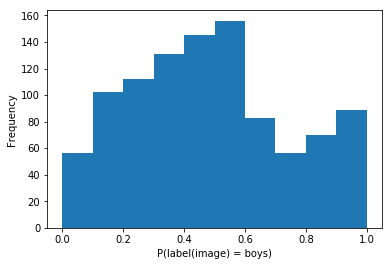

In [6]:
y_pred_prob = mod.predict_proba(x_test)

plt.hist(y_pred_prob[:, 0])
plt.xlabel('P(label(image) = boys)')
plt.ylabel('Frequency')
plt.show()

3. See if accuracy improves on a subset of test images the model is more "sure of", i.e. it scores them very high or very low:

In [7]:
from sklearn.metrics import confusion_matrix

y_pred_prob_1d = y_pred_prob[:, 0]
y_pred_low_high_id = np.argwhere(( y_pred_prob_1d <= 0.1) | (y_pred_prob_1d >= 0.9)).reshape(-1)
y_pred_low_high = y_pred_prob[y_pred_low_high_id, 0]
y_pred_low_high_temp = y_pred_low_high.copy()
y_pred_low_high[y_pred_low_high_temp < 0.5] = 1
y_pred_low_high[y_pred_low_high_temp > 0.5] = 0
y_test_low_high = y_test[y_pred_low_high_id]

conf = confusion_matrix(y_test_low_high, y_pred_low_high)
acc = (conf[0, 0] + conf[1, 1]) / len(y_test_low_high)
print('Test accuracy on all pixels with RF, only %.2f of images with very low/high scores: %.3f' % (len(y_test_low_high)/len(y_test), acc))

Test accuracy on all pixels with RF, only 0.15 of images with very low/high scores: 0.934


4. Repeat all of the above with Gradient Boosted Trees with 100 trees. You (almost!) only need to copy the code above. **If you're short on time try it with 10 trees at first**

    Please do not use the variable name `y_pred_prob_1d` again (the variable holding the 1D array of test images scores of being labelled "boys"), use a different variable name, you will need it soon.

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

mod = GradientBoostingClassifier(n_estimators = 100)
mod.fit(x_train, y_train)
acc = mod.score(x_test, y_test)
print('Test accuracy on all pixels with GBT: %.3f' % acc)

y_pred = mod.predict(x_test)
y_test_s = np.array(['boys'] * len(y_test))
y_pred_s = np.array(['boys'] * len(y_test))
y_test_s[y_test == 1] = 'girls'
y_pred_s[y_pred == 1] = 'girls'
conf_matrix(y_test_s, y_pred_s)

Test accuracy on all pixels with GBT: 0.758


Predicted,boys,girl,All
True,,,
boys,356,144,500
girl,98,402,500
All,454,546,1000


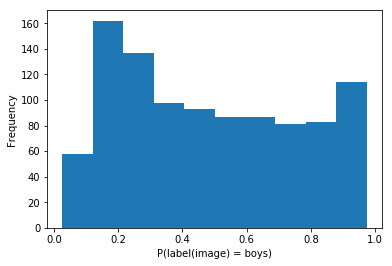

In [9]:
y_pred_prob = mod.predict_proba(x_test)

plt.hist(y_pred_prob[:, 0])
plt.xlabel('P(label(image) = boys)')
plt.ylabel('Frequency')
plt.show()

In [10]:
y_pred_prob_1d_gbt = y_pred_prob[:, 0]
y_pred_low_high_id = np.argwhere(( y_pred_prob_1d_gbt <= 0.1) | (y_pred_prob_1d_gbt >= 0.9)).reshape(-1)
y_pred_low_high = y_pred_prob[y_pred_low_high_id, 0]
y_pred_low_high_temp = y_pred_low_high.copy()
y_pred_low_high[y_pred_low_high_temp < 0.5] = 1
y_pred_low_high[y_pred_low_high_temp > 0.5] = 0
y_test_low_high = y_test[y_pred_low_high_id]

conf = confusion_matrix(y_test_low_high, y_pred_low_high)
acc = (conf[0, 0] + conf[1, 1]) / len(y_test_low_high)
print('Test accuracy on all pixels with GBT, only %.2f of images with very low/high scores: %.3f' % (len(y_test_low_high)/len(y_test), acc))

Test accuracy on all pixels with GBT, only 0.14 of images with very low/high scores: 0.956


5. Even with a balanced training set with two classes each having a share of 50% of the dataset, a cutoff score of 0.5 may not be optimal. Can you write a function which would receive the score `y_pred_prob_1d`, the score for classifying "boys", `y_test` the 0/1 labels, and return the cutoff score which reaches maximum accuracy and that accuracy?

In [11]:
def optimal_cutoff_accuracy(y_test, y_pred_prob_1d):
    optimal_cutoff = 0.0
    max_accuracy = 0.0
    for cutoff in np.linspace(0.0, 1.0, 101):
        y_pred_temp = np.array([0] * len(y_test))
        y_pred_temp[y_pred_prob_1d < cutoff] = 1
        conf = confusion_matrix(y_test, y_pred_temp)
        acc = (conf[0, 0] + conf[1, 1]) / len(y_test)
        if acc > max_accuracy:
            optimal_cutoff = cutoff
            max_accuracy = acc
    return optimal_cutoff, max_accuracy

optimal_cutoff, max_accuracy = optimal_cutoff_accuracy(y_test, y_pred_prob_1d)
print('optimal cutoff: %.2f' % optimal_cutoff)
print('max test accuracy: %.2f' % max_accuracy)

optimal cutoff: 0.49
max test accuracy: 0.76


**IMPORTNAT**: the correct way of choosing a cutoff score, which is another model parameter, is choosing it on a different *validation* dataset, not your final *testing* dataset. Otherwise you stand the risk of overfitting to your final testing set.

6. Once you accept the possibility of different thresholds, comparing between models based on a single default cutoff score such as 0.5, is wrong.

    It is custom to draw a [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) of the model's performance on a **validation** dataset and use the Area Under Curve ([AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)) to choose the best model to use on the final testing dataset. The AUC of a two-way classification model ranges between 0.5 (completely random guess) and 1 (completely correct), so the higher the AUC the better the model.

    The most common version of the ROC curve draws a line formed by comparing the following metrics with different cutoff scores:
    * True Positive Rate (TPR) which is what we have defined as Recall in CSD4: P(predict boys | label boys), you want this high
    * False Postive Rate (FPR), which is: P(predict boys | label girls), you want this low

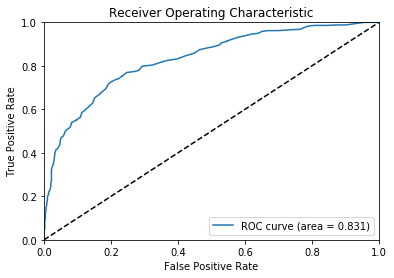

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_1d, pos_label=0)
roc_auc = roc_auc_score(1 - y_test, y_pred_prob_1d)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The above is the ROC curve for the Random Forests model, the AUC is printed in the plot.

Can you add the Gradient Boosted Trees ROC curve up there with a different color and compare the two AUCs?

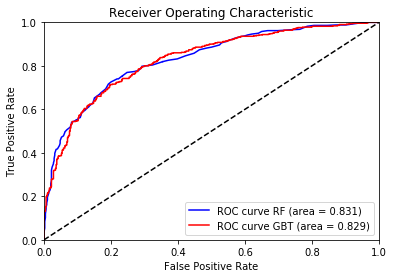

In [16]:
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred_prob_1d, 0)
roc_auc_rf = roc_auc_score(1 - y_test, y_pred_prob_1d)

fpr_gbt, tpr_gbt, thresholds = roc_curve(y_test, y_pred_prob_1d_gbt, 0)
roc_auc_gbt = roc_auc_score(1 - y_test, y_pred_prob_1d_gbt)

plt.plot(fpr_rf, tpr_rf, label='ROC curve RF (area = %0.3f)' % roc_auc_rf, color = 'blue')
plt.plot(fpr_gbt, tpr_gbt, label='ROC curve GBT (area = %0.3f)' % roc_auc_gbt, color = 'red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()